#  PyPHS Tutorial 1: The damped mechanical oscillator 

* Build the PHS associated with a damped oscillator (PyPHS `Core`)
* Play with the PHS structure (PyPHS `Core`)
* Simulation and signals generation (PyPHS `Simulation`)
<img src="files/figures/mka.png">

* Use of [Sympy](https://afalaize.github.io/posts/170614_ulr_python/) for symbolic computations in Python
* See also the [PyPHS Core tutorial](https://pyphs.github.io/pyphs/posts/tutos/pyphs-core/) and the [PyPHS Core primer](files/PyPHS_Core_primer.pdf)

#### Outline
1. Physical system and PHS equations
2. Instanciate a `Core` object
3. Add components
4. Add connections 
5. Add substitution values for parameters
6. Use the `Simulation` object
7. Plot results
8. Export signals

#### Additionnally

* Modulated damping coefficient
* Resisitive interconnection

## 1. Physical system

Mass $m$ glued to a stiffness $k$ and a damper $a$

<img src="files/figures/mka.png">


|  | Mass $m$ | Stiffness $k$ | Damper $a$ |
|----------|----------------------------------------|-------------------------------------------|----------------------------------|
| Variable | momentum $x_m = m \dot q$ | elongation $x_k = q$ | elongation rate $w_a = m \dot q$ |
| Function | kinetic $h_m(x_m) = \frac{x_m^2}{2 m}$ | potential $h_k(x_k) = \frac{k\,x_k^2}{2}$ | damping $z_a(w_a)=a\,w_a$  |
| Velocity | $v_m =\frac{x_m}{m}$ | $v_k= \dot x_k$ | $v_m =w_a$ |
| Force | $f_m = \dot x_m$ | $f_k = k \, x_m$ | $f_a = a \, w_a$ |

## Port-Hamiltonian Equations: 2 storages and 1 dissipation

* State $\mathbf x = (x_m, x_k)$,
* Storage function $\mathrm H(\mathbf x) = h_m(x_m) + h_k(x_k)$ with
    - $h_m(x_m) = \frac{x_m^2}{2 m}$
    - $h_k(x_k) = \frac{k\,x_k^2}{2}$
* Dissipation variable: $\mathbf w = (w_a)$,              
* Dissipation function: $\mathbf z(\mathbf w) = \big(z_a(w_a)\big)$,
* Connection
    * First line: Newton law $f_m = -f_k-f_r$, 
    * First column: Physical connection $ v_k = v_m = v_r$,
    * $\mathbf M = \mathbf J = \left(\begin{array}{rr|r}0 & -1 & - 1\\ +1 & 0 & 0\\ \hline +1 & 0 &0  \end{array} \right),
$
    * $\mathrm{dim}(\mathbf u) = 0$.

## 2. Instanciate a `Core` object

In [1]:
from pyphs import Core    # import the pyphs.Core class
label = 'dampedosc'       # system's label
core = Core(label)        # instanciate a Core object

## 3. Add components

`Core.add_storages(x, H)` with
* the state symbol(s) `x`,
* the storage function (expression) `H`.

`Core.add_dissipations(w, z)` with
* the dissipation variable(s) symbol(s) `w`,
* the dissipation function(s) (expression) `z`.    

#### Mass $m$:

In [2]:
xm = core.symbols('xm')    # mass state symbol
m = core.symbols('m')      # mass parameter symbol
hm = xm**2/(2.*m)          # kinetic energy expression
core.add_storages(xm, hm)  # add mass to Core

#### Stiffness $k$: 

In [3]:
xk, k = core.symbols(['xk', 'K0']) # stiffness symbols
hk = k*xk**2/2.                    # potential energy expression
core.add_storages(xk, hk)          # add stiffness to Core 

#### Damper $a$: 

In [4]:
wa, a = core.symbols(['w_a', 'a'])       # damper symbols
za = a*wa                                # damper expression
core.add_dissipations(wa, za)            # add damper to core

## 4. Add connections

Every blocks in $\mathbf M$ are zeros, except $\mathbf{J_{xx}} = \left(\begin{array}{rr}0 & -1 \\ +1 & 0 \end{array} \right)$ and $\mathbf{J_{xw}} = \left(\begin{array}{r} -1 \\ 0 \end{array} \right)$.

In [5]:
# update Jxx
core.set_Jxx([[0, -1],
             [+1, 0]])
# update Jxw
core.set_Jxw([[-1], 
             [0]])                      

In [6]:
# overview
core.pprint()

⎡⎡dxm⎤  ⎡0  -1  -1⎤  ⎡gxm⎤⎤
⎢⎢   ⎥  ⎢         ⎥  ⎢   ⎥⎥
⎢⎢dxk⎥, ⎢1  0   0 ⎥, ⎢gxk⎥⎥
⎢⎢   ⎥  ⎢         ⎥  ⎢   ⎥⎥
⎣⎣wₐ ⎦  ⎣1  0   0 ⎦  ⎣zₐ ⎦⎦


## 5. Add substitution values for parameters
Natural frequency $\omega=2\pi F=\sqrt{\frac{k}{m}}$ (rad.s$^{-1}$) $\Rightarrow$ choose stiffness $k=m(2 \pi F)^2$N.m$^{-1}$.

In [7]:
m_value = 0.1                         # mass value (kg)
F = 5e2                               # natural frequency (HZ)
k_value = m_value*(2*3.14157*F)**2    # stiffness value (N/m)
a_value = 1.                          # damper value (N.s/m)

In [8]:
# dictionary {symbols: values}
subs = {m: m_value, 
        k: k_value,
        a: a_value}

In [9]:
# update `Core.subs`
core.subs.update(subs)                

Apply substitutions: see method `Core.substitute`

## 6. Use the `Simulation` object

In [10]:
import os                                
config = {'fs': 1e4,                                 # sample rate (Hz)
          'path': os.path.join(os.getcwd(), label)   # folder for output results
         }
T = 1.                                               # simulation time (s)
nt = int(T*config['fs'])                             # number of time steps (int)

In [11]:
simu = core.to_simulation(config=config)   # `Simulation` object.
simu.method.x                              # get state ordering

In [12]:
inits = {'x': [0.1, 0.]}                  # initial values
simu.init(nt=nt, inits=inits)             # initialize `Data` object

In [13]:
simu.process()                            # process

## 7. Plot results
Use the `Data` object:

In [14]:
x = list(simu.data.x())         # get a list of vectors
dxhm = list(simu.data.dxH(0))   # get a list of scalars
w = list(simu.data.w())         # get a list of vectors
za = list(simu.data.z(0))       # get a list of scalars

### Power balance

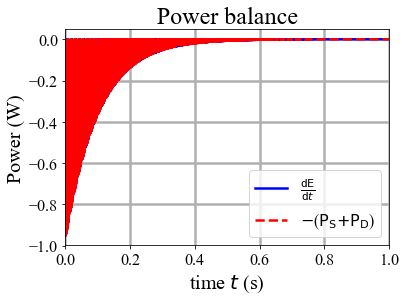

In [15]:
simu.data.plot_powerbal()

### Time series

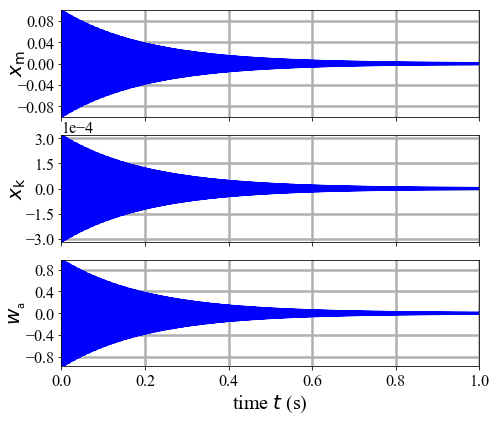

In [16]:
simu.data.plot(('x', 'w'))

### Time series (zoom)

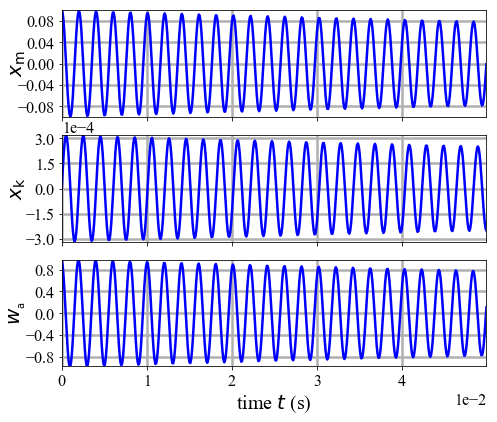

In [17]:
simu.data.plot(('x', 'w'), load={'imax':500})

## 8. Export signals
Each signal ($\mathbf x$, $\nabla \mathrm H$, $\mathbf w$, $\mathbf z$, etc) and can be exported as a mono `.wav` file

In [18]:
path = os.path.join(simu.config['path'], 'damped_oscillator') 
simu.data.wavwrite('x', 0, path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/PyPHS_TUTO_IRCAM/PyPHS_tuto1_oscillator/dampedosc/damped_oscillator
Convert generator to list...
Fade begining and ending...
Write wave file...


## Additionnally: Modulated damping coefficient
Below we change damping coefficient $a\leftarrow R_x(x_m) = 5\exp\left(-10\left(\frac{x_m}{p_{0}}\right)^2\right)$

In [19]:
import sympy
p0 = inits['x'][0]                     # initial value for xm
Rx = 5*sympy.exp(-10*(xm/p0)**2)       # damping modulated by xm value
core.subs[a] = Rx                      # damper coefficient substitution

In [20]:
simu = core.to_simulation(config=config) # `Simulation` object.
simu.init(nt=nt, inits=inits)            # initialize `Data` object
simu.process()                           # process

### Power balance

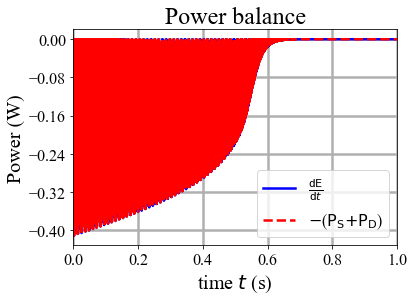

In [21]:
simu.data.plot_powerbal()

### Time series

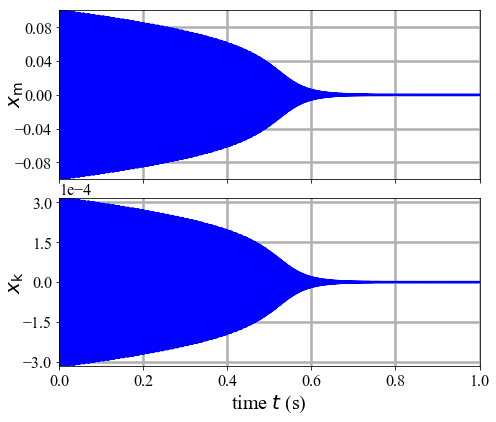

In [22]:
simu.data.plot('x')

### Time series (zoom)

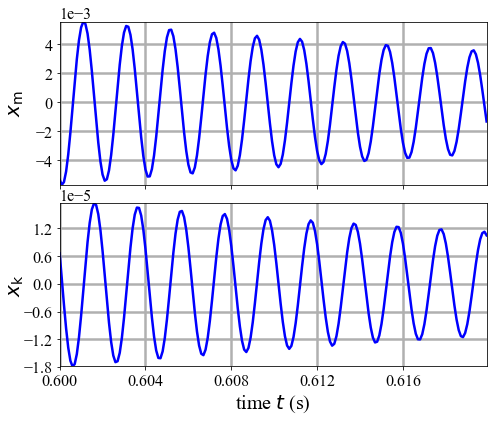

In [23]:
simu.data.plot('x', load={'imin':6000, 'imax':6200})

### Signals

In [24]:
path = os.path.join(simu.config['path'], 'damped_oscillator2') 
simu.data.wavwrite('x', 0, path=path)

/Users/afalaize/Desktop/171204_Séminaire_PyPHS/PyPHS_TUTO_IRCAM/PyPHS_tuto1_oscillator/dampedosc/damped_oscillator2
Convert generator to list...
Fade begining and ending...
Write wave file...


## Additionnally: Resisitive interconnection


In [25]:
print( core.w, core.z)        # dissipation variable and function
core.M, core.J(), core.R()    # interconnection M = J - R

[w_a] [a*w_a]


⎛⎡0  -1  -1⎤  ⎡ 0   -1.0  -1.0⎤  ⎡0  0  0⎤⎞
⎜⎢         ⎥  ⎢               ⎥  ⎢       ⎥⎟
⎜⎢1  0   0 ⎥, ⎢1.0   0     0  ⎥, ⎢0  0  0⎥⎟
⎜⎢         ⎥  ⎢               ⎥  ⎢       ⎥⎟
⎝⎣1  0   0 ⎦  ⎣1.0   0     0  ⎦  ⎣0  0  0⎦⎠

In [26]:
core.reduce_z()              # Reduce the linear dissipations
print( core.w, core.z)        # dissipation variable and function
core.M, core.J(), core.R()    # interconnection M = J - R

[] []


⎛⎡-a  -1⎤  ⎡ 0   -1.0⎤  ⎡1.0⋅a  0⎤⎞
⎜⎢      ⎥, ⎢         ⎥, ⎢        ⎥⎟
⎝⎣1   0 ⎦  ⎣1.0   0  ⎦  ⎣  0    0⎦⎠